# **Training With HuggingFace Accelerate + Pytorch Custom Trainer**
___

> My model just wouldn't train with my custom trainer or pytorch lightning. Didn't understand why so chose to modify the training loops with Accelerate and it works pretty well now!

> with un-freezed `deberta-v3-base`, the approx GPU consumption is around 11.2 GB with these hyperparameters

> Optimization: Gradient Accumulation (steps=2)


### Another notebook you can check out for (bert-base-uncased): [Using 🤗 Transformers for the first time | Pytorch](https://www.kaggle.com/code/shreydan/using-transformers-for-the-first-time-pytorch)

In [1]:
from transformers import AutoModel
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gc

from accelerate import Accelerator

# ----------
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
config = {
    'model': 'microsoft/deberta-v3-base',
    'dropout': 0.5,
    'max_length': 512,
    'batch_size': 8, # anything more results in CUDA OOM [for unfreezed encoder] on Kaggle GPU
    'epochs': 7,
    'lr': 3e-4,
    'enable_scheduler': True,
    'scheduler': 'CosineAnnealingWarmRestarts',
    'gradient_accumulation_steps': 2,
    'adam_eps': 1e-6, # 1e-8 default
    'freeze_encoder': True
}

In [3]:
print(config)

{'model': 'microsoft/deberta-v3-base', 'dropout': 0.5, 'max_length': 512, 'batch_size': 8, 'epochs': 7, 'lr': 0.0003, 'enable_scheduler': True, 'scheduler': 'CosineAnnealingWarmRestarts', 'gradient_accumulation_steps': 2, 'adam_eps': 1e-06, 'freeze_encoder': True}


In [4]:
tokenizer = AutoTokenizer.from_pretrained(config['model'])

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
df = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
test_df = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')

In [6]:
test_df.head()

,text_id,full_text
0,0000C359D63E,when a person has no experience on a job their...
1,000BAD50D026,Do you think students would benefit from being...
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde..."


In [7]:
print(df.columns.to_list())

['text_id', 'full_text', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']


In [8]:
class EssayDataset:
    def __init__(self, df, config, tokenizer=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.classes = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
        self.max_len = config['max_length']
        self.tokenizer = tokenizer
        self.is_test = is_test
        
    def __getitem__(self,idx):
        sample = self.df['full_text'][idx]
        tokenized = tokenizer.encode_plus(sample,
                                          None,
                                          add_special_tokens=True,
                                          max_length=self.max_len,
                                          truncation=True,
                                          padding='max_length'
                                         )
        inputs = {
            "input_ids": torch.tensor(tokenized['input_ids'], dtype=torch.long),
            "token_type_ids": torch.tensor(tokenized['token_type_ids'], dtype=torch.long),
            "attention_mask": torch.tensor(tokenized['attention_mask'], dtype=torch.long)
        }
        
        if self.is_test == True:
            return inputs
        
        label = self.df.loc[idx,self.classes].to_list()
        targets = {
            "labels": torch.tensor(label, dtype=torch.float32),
        }
        
        return inputs, targets
    
    def __len__(self):
        return len(self.df)


In [9]:
train_df, val_df = train_test_split(df,test_size=0.2,random_state=1357,shuffle=True)
print('dataframe shapes:',train_df.shape, val_df.shape)

dataframe shapes: (3128, 8) (783, 8)


In [10]:
train_ds = EssayDataset(train_df, config, tokenizer=tokenizer)
val_ds = EssayDataset(val_df, config, tokenizer=tokenizer)
test_ds = EssayDataset(test_df, config, tokenizer=tokenizer, is_test=True)

In [11]:
train_ds[0][0].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [12]:
train_loader = torch.utils.data.DataLoader(train_ds,
                                           batch_size=config['batch_size'],
                                           shuffle=True,
                                           num_workers=2,
                                           pin_memory=True
                                          )
val_loader = torch.utils.data.DataLoader(val_ds,
                                         batch_size=config['batch_size'],
                                         shuffle=True,
                                         num_workers=2,
                                         pin_memory=True
                                        )

In [13]:
print('loader shapes:',len(train_loader), len(val_loader))

loader shapes: 391 98


# Model
<div style="width:100%;height:0;border-bottom: 3px solid #C3F307;margin-bottom: 1rem;"></div>

Mean Pooling src from [@debarshichanda](https://www.kaggle.com/code/debarshichanda/fb3-custom-hf-trainer-w-b-starter?scriptVersionId=104880636&cellId=24)

In [14]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [15]:
class EssayModel(nn.Module):
    def __init__(self,config,num_classes=6):
        super(EssayModel,self).__init__()
        self.model_name = config['model']
        self.freeze = config['freeze_encoder']
        
        self.encoder = AutoModel.from_pretrained(self.model_name)
        if self.freeze:
            for param in self.encoder.base_model.parameters():
                param.requires_grad = False
                
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(config['dropout'])
        self.fc1 = nn.Linear(self.encoder.config.hidden_size,64)
        self.fc2 = nn.Linear(64,num_classes)
        
        
    def forward(self,inputs):
        outputs = self.encoder(**inputs,return_dict=True)
        outputs = self.pooler(outputs['last_hidden_state'], inputs['attention_mask'])
        outputs = self.fc1(outputs)
        outputs = self.fc2(outputs)
        return outputs

# Trainer
<div style="width:100%;height:0;border-bottom: 3px solid #e7eb1a;margin-bottom: 1rem;"></div>


In [16]:
class Trainer:
    def __init__(self, model, loaders, config, accelerator):
        self.model = model
        self.train_loader, self.val_loader = loaders
        self.config = config
        self.input_keys = ['input_ids','token_type_ids','attention_mask']
        self.accelerator = accelerator
        
        self.optim = self._get_optim()
        
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optim, T_0=5,eta_min=1e-7)
        
        self.train_losses = []
        self.val_losses = []
        
    def prepare(self):
        self.model, self.optim, self.train_loader, self.val_loader, self.scheduler = self.accelerator.prepare(
            self.model, 
            self.optim, 
            self.train_loader, 
            self.val_loader, 
            self.scheduler
        )
        
    def _get_optim(self):
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
            {'params': [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=self.config['lr'], eps=self.config['adam_eps'])
        return optimizer

        
    def loss_fn(self, outputs, targets):
        colwise_mse = torch.mean(torch.square(targets - outputs), dim=0)
        loss = torch.mean(torch.sqrt(colwise_mse), dim=0)
        return loss
    
    
    def train_one_epoch(self,epoch):
        
        running_loss = 0.
        progress = tqdm(self.train_loader, total=len(self.train_loader))
        
        for idx,(inputs,targets) in enumerate(progress):
            with self.accelerator.accumulate(self.model):
            
                outputs = self.model(inputs)

                loss = self.loss_fn(outputs, targets['labels'])
                running_loss += loss.item()

                self.accelerator.backward(loss)
                
                self.optim.step()
                
                if self.config['enable_scheduler']:
                    self.scheduler.step(epoch - 1 + idx / len(self.train_loader))
                    
                self.optim.zero_grad()

                del inputs, targets, outputs, loss
            
            
        train_loss = running_loss/len(self.train_loader)
        self.train_losses.append(train_loss)
        
    @torch.no_grad()
    def valid_one_epoch(self,epoch):
        
        running_loss = 0.
        progress = tqdm(self.val_loader, total=len(self.val_loader))
        
        for (inputs, targets) in progress:
            
            outputs = self.model(inputs)
            
            loss = self.loss_fn(outputs, targets['labels'])
            running_loss += loss.item()
            
            del inputs, targets, outputs, loss
            
        
        val_loss = running_loss/len(self.val_loader)
        self.val_losses.append(val_loss)
        
    
    def test(self, test_loader):
        
        preds = []
        for (inputs) in test_loader:
            
            outputs = self.model(inputs)
            preds.append(outputs.detach().cpu())
            
        preds = torch.concat(preds)
        return preds
    
    def fit(self):
        
        self.prepare()
        
        fit_progress = tqdm(
            range(1, self.config['epochs']+1),
            leave = True,
            desc="Training..."
        )
        
        for epoch in fit_progress:
            
            self.model.train()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | training...")
            self.train_one_epoch(epoch)
            self.clear()
            
            self.model.eval()
            fit_progress.set_description(f"EPOCH {epoch} / {self.config['epochs']} | validating...")
            self.valid_one_epoch(epoch)
            self.clear()

            print(f"{'➖️'*10} EPOCH {epoch} / {self.config['epochs']} {'➖️'*10}")
            print(f"train loss: {self.train_losses[-1]}")
            print(f"valid loss: {self.val_losses[-1]}\n\n")
            
    
    def clear(self):
        gc.collect()
        torch.cuda.empty_cache()

# Training with HuggingFace Accelerate
<div style="width:100%;height:0;border-bottom: 3px solid #7FF906;margin-bottom: 1rem;"></div>

In [17]:
accelerator = Accelerator(gradient_accumulation_steps=config['gradient_accumulation_steps'])

In [18]:
model = EssayModel(config).to(device=accelerator.device)
trainer = Trainer(model, (train_loader, val_loader), config, accelerator)

Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
trainer.fit()

Training...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 1 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.7283471520904385
valid loss: 0.4867040852502901




  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 2 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.47081817194933784
valid loss: 0.48075777413893717




  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 3 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4584202789284689
valid loss: 0.5133748148777046




  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 4 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.44971495889641744
valid loss: 0.4751293282119595




  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 5 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4476741727660684
valid loss: 0.4702793621287054




  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 6 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4568147001516484
valid loss: 0.45891164638558213




  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️ EPOCH 7 / 7 ➖️➖️➖️➖️➖️➖️➖️➖️➖️➖️
train loss: 0.4528857677641427
valid loss: 0.46153203534836673




# Results
<div style="width:100%;height:0;border-bottom: 3px solid #EAB209;margin-bottom: 1rem;"></div>

In [20]:
losses_df = pd.DataFrame({'epoch':list(range(1,config['epochs'] + 1)),
                          'train_loss':trainer.train_losses, 
                          'val_loss': trainer.val_losses
                         })

In [21]:
losses_df

,epoch,train_loss,val_loss
0,1,0.728347,0.486704
1,2,0.470818,0.480758
2,3,0.458420,0.513375
3,4,0.449715,0.475129
4,5,0.447674,0.470279
5,6,0.456815,0.458912
6,7,0.452886,0.461532


# Plots
<div style="width:100%;height:0;border-bottom: 3px solid #EDD608;margin-bottom: 1rem;"></div>

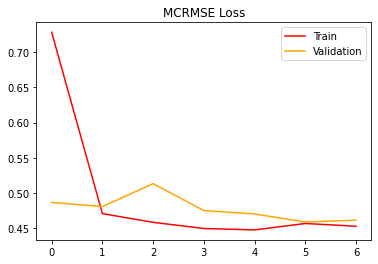

In [22]:
plt.plot(trainer.train_losses, color='red')
plt.plot(trainer.val_losses, color='orange')
plt.title('MCRMSE Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# References
<div style="width:100%;height:0;border-bottom: 3px solid #C3F307;margin-bottom: 1rem;"></div>

- optimization techniques: [by user @vad13irt](https://www.kaggle.com/code/vad13irt/optimization-approaches-for-transformers)
- gradient accumulation usage: [🤗 docs](https://huggingface.co/docs/accelerate/usage_guides/gradient_accumulation)
- accelerate: [🤗 docs](https://huggingface.co/docs/accelerate/basic_tutorials/migration)
- trainer: [using-transformers-for-the-first-time-pytorch](https://www.kaggle.com/code/shreydan/using-transformers-for-the-first-time-pytorch)

<center><h1>Upvote & Follow if you like my work! <a href="https://kaggle.com/shreydan">@shreydan</a></h1><center>